# 멋진 단어사전을 만들어보자.

## 목차

1. 데이터 EDA
2. 공백 기반 토큰화
3. 형태소 기반 토큰화
4. SentencePiece 토큰화

형태소 분석기로 Mecab을 사용한다.

Mecab은 토큰화를 도와주는 라이브러리로 성능이 좋기로 알려졌다. 일본어 형태소 분리 모델로 개발되었지만 한국어에도 훌륭하게 적용되었다.

In [1]:
from konlpy.tag import Mecab  # import Mecab.

mecab = Mecab()    # Generate Mecab instance.
print(mecab.morphs('자연어처리가너무재밌어서밥먹는것도가끔까먹어요'))  # execute morphs method in Mecab

['자연어', '처리', '가', '너무', '재밌', '어서', '밥', '먹', '는', '것', '도', '가끔', '까먹', '어요']


형태소 별로 분석리가 되었다.

## 1. 데이터 EDA

In [2]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

%matplotlib inline

'korean-english-park.train.ko'는 한-영 말뭉치 데이터로 한국어 형태소 분석 품사 태깅 등 연구를 위해 공개된 데이터다.

데이터셋의 한국어 부분만 먼저 읽어보자.

In [3]:
import os
path_to_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.


문장 데이터 개수는 94,123개가 된다.

전체 문장 데이터의 최장 길이 최단길이 평균길이를 알아내보자.

문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 60


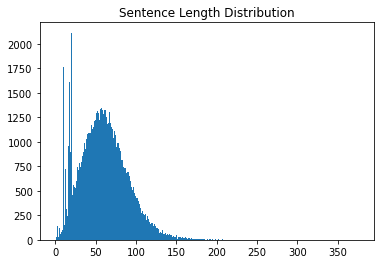

In [4]:
min_len = 999 # 최단 거리 초기값을 크게 두고 아래로 내려가도록 변수 선언
max_len = 0   # 최대값이 0인 변수로 선언하여 탐색
sum_len = 0   # 길이 합계 변수도 0으로 선언

for sen in raw:          # 데이터 리스트의 자료를 하나씩 불러와서
    length = len(sen)    # 길이를 length 변수에 넣는다.
    if min_len > length: min_len = length   # 최단 길이 초기값보다 작으면 길이 값을 최단거리에 넣는다.
    if max_len < length: max_len = length   # 최장 길이 초기값보다 큰 길이를 가지면 업데이트시킨다.
    sum_len += length    # 길이를 sum_len에 더해준다.

print("문장의 최단 길이:", min_len)   # 최단 길이를 출력한다.
print("문장의 최장 길이:", max_len)   # 최장 길이를 출력한다.
print("문장의 평균 길이:", sum_len // len(raw))   # 문장의 평균길이를 출력한다.(계산한 합계를 데이터수로 나눈다)

sentence_length = np.zeros((max_len), dtype=int)  # 최장 길이만큼 사이즈를 가진 리스트(1,man_len 크기의 0행렬)

for sen in raw:   # 데이터에서 sen의 값을 불러와서
    sentence_length[len(sen)-1] += 1  # 최장 길이를 인덱스로 하는 곳의 값을 하나씩 키워주면서 카운트한다.

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

최단길이와 최장길이의 범위가 매우 크다.

고민이 드는 지점으로
1. 길이 1짜리 문장은 어떤걸까?
2. 평균 이전에 튀는 구간들을 어떤 의미를 가진것일까?
3. 어디서 어디까지 잘라서 써야하나?

데이터에서 특정 길이, length를 가진 문장을 출력하고 count가 100이 넘으면 종료하는 함수를 만든다.

In [5]:
def check_sentence_with_length(raw, length):    # 데이터에서 특정 길이를 가진 문장을 찾는 함수
    count = 0   # 카운트 변수 선언
    
    for sen in raw:   # 함수의 입력된 데이터에서 문장을 하나씩 불러온다.
        if len(sen) == length:  # 불러온 문장의 길이가 우리가 원하는 특정문장이면
            print(sen)          # 출력하고
            count += 1          # 카운트 변수를 하나 키운다.
            if count > 100: return   # 카운트가 100을 넘기면 함수를 종료한다.

check_sentence_with_length(raw, 1)

’


문장수가 1500개 이상인 문장 길이 인덱스를 찾아보자.

In [6]:
for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 1500을 초과하는 문장 길이를 추출합니다.
    if _sum > 1500:
        print("Outlier Index:", idx+1)

Outlier Index: 11
Outlier Index: 19
Outlier Index: 21


11, 19, 21의 인덱스에서 문장수가 특별히 많았다. 11의 인덱스를 먼저 탐색해보자.

In [7]:
check_sentence_with_length(raw, 11)

라고 조던이 말했다.
- 모르고 있습니다.
- 네, 보이는군요.
디즈니사만이 아니다.
큰 파티는 아니지요.
의자는 비어 있었다.
이 일은 계속됩니다.
나는 크게 실망했다.
그 이유는 간단하다.
이력서와 자기 소개서
시대가 변하고 있다.
는 돌발질문을 했다.
9. 몇 분간의 명상
하와이, 빅 아일랜드
키스를 잘 하는 방법
키스를 잘 하는 방법
스피어스가 뚱뚱한가?
산 위를 나는 느낌.
세 시간쯤 걸었을까?
(아직 읽고있습니까?
처음에는 장난이었다.
우리는 운이 좋았다.
아기가 숨을 멈출 때
건물 전체 무너져내려
그녀의 아름다운 눈.
대답은 다음과 같다.
"사과할 것이 없다.
폭탄테러가 공포 유발
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
그는 "잘 모르겠다.
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1200원대로…
더 내려야 하는 이유
케냐 야생동물 고아원
경유 1

보니까 중복된 것들이 많다. 어떤 문장길이에서 특별히 많이 발견되는 의미가 있진 않고
중복값으로 인한 거 같아 보인다.

파이썬에서 set 자료형을 이용하면 중복된 요소는 자동으로 정리된다.

Data Size: 77591
문장의 최단 길이: 1
문장의 최장 길이: 377
문장의 평균 길이: 64


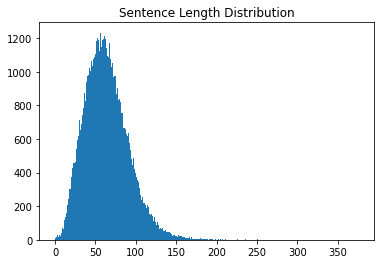

In [8]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

중복값을 제거했더니 이상치가 없어졌다. 데이터의 개수도 17,000여개가 줄었다.

마지막으로 패딩처리하기전에 어느 문장길이 데이터까지 사용해야 효율적일 지 고민해보자.

여기서는 최대길이 150에서 끊고, 최소길이 10이하는 끊어서 사용한다.

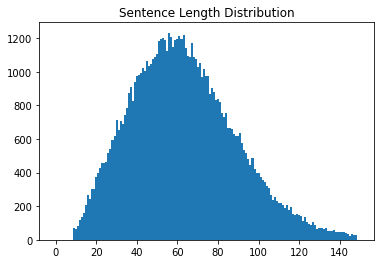

In [9]:
max_len = 150
min_len = 10

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

# 2. 공백기반 토큰화

keras의 토큰화 함수를 사용하여 공백 기반 토큰화를 실습해보자.

In [10]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [11]:
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

In [12]:
split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 237435


In [13]:
for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 이
1 : 밝혔다.
2 : 있다.
3 : 말했다.
4 : 수
5 : 있는
6 : 그는
7 : 대한
8 : 위해
9 : 전했다.
10 : 지난
11 : 이번


# 3. 형태소 기반 토큰화

한국어 형태소 분석기는 대표적으로 khaiii와 KoNLPy가 사용됩니다.
KoNLPy중에서도 성능이 가장 준수한 Mecab클래스를 활용해 실습해보자.

In [14]:
def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))

In [15]:
mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 52279


# 프로젝트 : SentencePiece 사용하기

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


## 1. SentencePiece 설치하기

SentencePiece는 Google에서 제공하는 오픈소스 기반 Sentence Tokenizer/Detokenizer 로서, BPE와 unigram 2가지 subword 토크나이징 모델 중 하나를 선택해서 사용할 수 있도록 패키징한 것입니다. 아래 링크의 페이지에서 상세한 내용을 파악할 수 있습니다.

[google/sentencepiece](https://github.com/google/sentencepiece)

위 페이지의 서두에서도 언급하고 있듯, SentencePiece는 딥러닝 자연어처리 모델의 앞부분에 사용할 목적으로 최적화되어 있는데, 최근 pretrained model들이 거의 대부분 SentencePiece를 tokenizer로 채용하면서 사실상 표준의 역할을 하고 있습니다.

다음과 같이 설치를 진행합니다. SentencePiece는 python에서 쓰라고 만들어진 라이브러리는 아니지만 편리한 파이썬 wrapper를 아래와 같이 제공하고 있습니다.

## 2. SentencePiece 모델 학습하기

아래와 같이 tf.keras.preprocessing.text.Tokenizer에 corpus를 주고 tokenizer.fit_on_texts(corpus)을 하면 토크나이저 내부적으로 단어사전과 토크나이저 기능을 corpus에 맞춤형으로 자동 생성해 주는 것입니다.

그럼 이를 위해서 SentencePiece 모델을 학습하는 과정을 거쳐야 합니다.

In [17]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [18]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 376816 Nov 28 02:28 korean_spm.model
-rw-r--r-- 1 root root 146213 Nov 28 02:28 korean_spm.vocab


In [26]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1243, 11, 302, 7, 3608, 11, 287, 38, 3]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


## 3. Tokenizer 함수 작성

우리는 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의할 겁니다. 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵습니다. 그러니 아래 조건을 만족하는 함수를 정의하도록 하습니다.

매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

In [28]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [29]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[1956 5665    5    4 7975 1990    3    0    0    0    0    0    0    0]
 [ 107 1641  101    4    0  417   11    4   14    0 1976    3    3    3]]


## 4. 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용하기

[네이버 영화리뷰 감정 분석 태스크](https://github.com/e9t/nsmc)

네이버 영화리뷰 감정 분석 태스크가 있습니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용하게 되는데요.

만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? KoNLPy에 있는 Mecab, kkma, Okt 등과 비교해보세요.

네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기
학습된 모델로 sp_tokenize() 메소드 구현하기
구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기
KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기
SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기
Word Vector는 활용할 필요가 없습니다. 활용이 가능하지도 않을 것입니다.

## 4-1. 데이터 준비

In [74]:
import pandas
import konlpy
import gensim

import tensorflow as tf
import os
from nltk import FreqDist

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

import matplotlib.pyplot as plt

%matplotlib inline

1.3.3
0.5.2
4.1.2


In [75]:
import numpy as np
import pandas as pd

# 데이터를 읽어봅시다. 
import os
temp_dir = os.getenv('HOME')+'/aiffel/sp_tokenizer/nsmc-master/'

train_data = pd.read_table(temp_dir + 'ratings_train.txt')
test_data = pd.read_table(temp_dir + 'ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 4-2. 데이터로더 구성

imdb 데이터셋과 다르게 이번 네이버 영화리뷰 데이터셋은 직접 전처리하여 word_to_index를 구성해야한다.

### 데이터로더 작업 요소

- 데이터의 중복제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

### 중복 제거

In [77]:
train_data.duplicated().sum()

0

학습데이터에서 중복값은 없다.

In [78]:
train_data['document'].duplicated().sum()

3817

학습데이터 리뷰 본문내용에는 중복값들이 있다.

중복값들을 확인해보자. 먼저 중복데이터들을 확인할 컬럼을 가진 임시 데이터프레임을 만들자.

In [79]:
temp_train = train_data.copy()

temp_train['duplicated'] = train_data['document'].duplicated()

temp_train.head()

,id,document,label,duplicated
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,False
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,False
2,10265843,너무재밓었다그래서보는것을추천한다,0,False
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,False
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,False


중복데이터들의 리뷰 내용들을 보자.

In [80]:
temp_train[temp_train['duplicated'] == True]

,id,document,label,duplicated
1058,5890638,4,0,True
1097,2062443,쵝오,1,True
1248,3502685,최고,1,True
1483,775332,최고,1,True
1707,8009134,재밌다,1,True
...,...,...,...,...
149919,6502490,짱,1,True
149949,3924716,OO 영화,0,True
149960,6368431,지루하다,0,True
149966,6735753,1,0,True


중복 문장들이 있는데, 단어사전을 만들 때, set 자료형을 이용해 중복값을 없애도록 한다.

테스트 데이터들도 똑같이보쟈

In [81]:
test_data.duplicated().sum()

0

중복값이 없다.

In [82]:
test_data['document'].duplicated().sum()

842

하지만 학습데이터와 마찬가지로 테스트 데이터 리뷰 본문의 중복값들이 있다

In [83]:
temp_test = test_data.copy()

temp_test['duplicated'] = temp_test['document'].duplicated()

temp_test

,id,document,label,duplicated
0,6270596,굳 ㅋ,1,False
1,9274899,GDNTOPCLASSINTHECLUB,0,False
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0,False
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0,False
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0,False
...,...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1,False
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0,False
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0,False
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0,False


In [84]:
temp_test[temp_test['duplicated'] == True]

,id,document,label,duplicated
857,2084375,bad,0,True
956,195683,재미있어요,1,True
1089,2235528,볼만함,1,True
1149,4409686,굿,1,True
1600,3805716,최고,1,True
...,...,...,...,...
49731,7437033,별로,0,True
49760,5890883,최악이다,0,True
49767,4032953,최고,1,True
49841,8097768,2년이 지나도 잊혀지지 않는 소중한 드라마.,1,True


중복 문장들이 있는데, 단어사전을 만들 때, set 자료형을 이용해 중복값을 없애도록 한다.

### 결측치 제거

In [85]:
train_data.dropna(subset=['document'], inplace=True)             # 학습데이터 결측치 제거
test_data.dropna(subset=['document'], inplace=True)             # 학습데이터 결측치 제거

In [88]:
set(train_data['document'])

{'시선과 얼굴의 떨림 만으로도 감정 표현이 가능함을 보여준 작품',
 '넌센스다...',
 '간만에보는 예쁜드라마~',
 '본 사람이 그리 많지 않네? 재미는 별로',
 '진짜 뭐라고 말할수없을정도로 엄청난 충격을 준 명작이자 괴작랄까 에반게리온. 넌 날 오덕의 길로 가게만들었어.',
 '존꿀잼...노래나 스토리도 좋고 캐릭터들도 너무나 재밌다 난생 처음으로 디즈니 베이비돌이 사고싶어짐',
 '세상이 똥이라는 걸 꼭 빅똥을 투척하면서 강조해야겠냐 으이구',
 '마지막에 굳이 희생을통해 남은이의 삶을 굳건하게 할수밖엔 없는건가 하는 생각에 마음이 먹먹해진다',
 '손발이 오글거린다란 바로 이영화를 두고 하는 말이다.',
 '폴라익스프레스 - 2004',
 '긴장감, 몰입도 모두 괜찮았다. 스필버그의 Duel과는 또 다른 재미였음',
 '박보영 최고.... 2년전에 개봉 했으니까 정말 이상하다..............',
 "시위를 법으로 금지해놓진 않지만 '불법'시위라고 괜히 말하는게 아니죠^^ 저런 시위가 나라의 독같은 존재 같고 제일 피해를 입은 의경,전경들의 고생에 노고를 표합니다.^^지나가던 시민들도 저런 쓰레기 같은 폭도들 때문에 고생좀 했었죠^^",
 '자연스러운 흐름에 편승해 보세요. 100분이 그냥 지나갑니다.',
 '쓰렉영화',
 '아가들이랑보기에~~딱이죠^^',
 '완전재밌음!!!에스키모에 대한 건 처음봐요',
 '어렸을 적 재미있게 봤던 영화입니다. 이 영화를 비디오 테잎으로 소장하고 있는데 요즘 비디오 플레이어를 구할수 없어서 서랍속에 묵혀두고 있는데.. 파일로 소장 하신 분 계시나요?',
 '아.............뭐..................그냥..............시간 아깝다 ㅜㅜ',
 '재미도 있고 웃기기도 하다.',
 '잘보고있어요!! 이번주 화요일은 시험기간이라고 못봤어요.. 저 울음.. 엄마 혼자 봤어요..',
 '액션이라기 보다는 코메디에 가까운 영화. 그럼에도 불구하고 재밌는 영화.',
 '내용도 없고... 여주

Data Size: 146182
문장의 최단 길이: 1
문장의 최장 길이: 146
문장의 평균 길이: 35


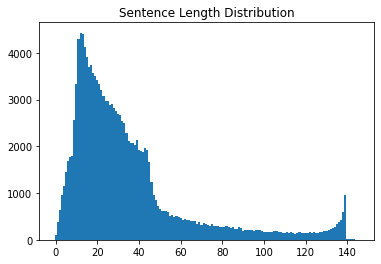

In [89]:
min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(train_data['document']))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

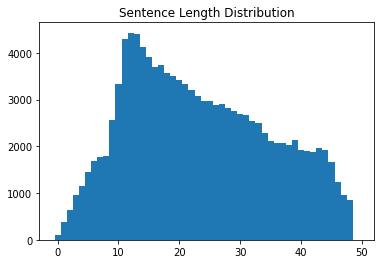

In [91]:
max_len = 50
min_len = 1

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [92]:
import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전 스텝에서 정제했던 corpus를 활용합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = 'unigram'이 디폴트 적용되어 있습니다. --model_type = 'bpe' 로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 375436 Nov 28 08:10 korean_spm.model
-rw-r--r-- 1 root root 144959 Nov 28 08:10 korean_spm.vocab


In [93]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1702, 10, 402, 16, 1418, 10, 155, 14, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [94]:
def sp_tokenize(s, corpus):

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [95]:
#sp_tokenize(s, corpus) 사용예제

my_corpus = ['나는 밥을 먹었습니다.', '그러나 여전히 ㅠㅠ 배가 고픕니다...']
tensor, word_index, index_word = sp_tokenize(s, my_corpus)
print(tensor)

[[ 499 2956   15 1134 2345    4    0    0    0    0]
 [1431 2080  242  508   10    3   18 7902  791    8]]


In [123]:
filtered_corpus[:5]

['시선과 얼굴의 떨림 만으로도 감정 표현이 가능함을 보여준 작품',
 '넌센스다...',
 '간만에보는 예쁜드라마~',
 '본 사람이 그리 많지 않네? 재미는 별로',
 '세상이 똥이라는 걸 꼭 빅똥을 투척하면서 강조해야겠냐 으이구']

In [124]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus)
print(tensor)

[[2458   40 1420 ...    0    0    0]
 [4188 2881   14 ...    0    0    0]
 [ 912  651 2480 ...    0    0    0]
 ...
 [   3 1543  488 ...    0    0    0]
 [  47   44  677 ...    0    0    0]
 [4059 6426   40 ...    0    0    0]]


In [120]:
tensor

array([[2458,   40, 1420, ...,    0,    0,    0],
       [4188, 2881,   14, ...,    0,    0,    0],
       [ 912,  651, 2480, ...,    0,    0,    0],
       ...,
       [   3, 1543,  488, ...,    0,    0,    0],
       [  47,   44,  677, ...,    0,    0,    0],
       [4059, 6426,   40, ...,    0,    0,    0]], dtype=int32)

In [121]:
tensor_train = tensor[:119996]
tensor_val = tensor[119996:]

In [100]:
word_index

{'<unk>': 0,
 '<s>': 1,
 '</s>': 2,
 '▁': 3,
 '.': 4,
 '..': 5,
 '▁영화': 6,
 '이': 7,
 '...': 8,
 '의': 9,
 '가': 10,
 '도': 11,
 '는': 12,
 ',': 13,
 '다': 14,
 '을': 15,
 '에': 16,
 '은': 17,
 '고': 18,
 '?': 19,
 '지': 20,
 '!': 21,
 '한': 22,
 '▁너무': 23,
 '▁정말': 24,
 '만': 25,
 '를': 26,
 '~': 27,
 '로': 28,
 '영화': 29,
 '▁이': 30,
 '▁진짜': 31,
 '나': 32,
 '게': 33,
 '어': 34,
 '리': 35,
 '라': 36,
 '네': 37,
 '점': 38,
 '아': 39,
 '과': 40,
 '기': 41,
 '!!': 42,
 '인': 43,
 '....': 44,
 '▁1': 45,
 '▁왜': 46,
 '▁아': 47,
 '▁잘': 48,
 '▁안': 49,
 '들': 50,
 '서': 51,
 '하고': 52,
 '으로': 53,
 '▁이런': 54,
 '요': 55,
 '자': 56,
 '에서': 57,
 '와': 58,
 '네요': 59,
 '▁그': 60,
 '해': 61,
 '▁더': 62,
 '▁수': 63,
 '▁그냥': 64,
 '스': 65,
 '▁10': 66,
 '▁다': 67,
 '▁본': 68,
 '▁드라마': 69,
 '거': 70,
 '음': 71,
 '수': 72,
 '▁평점': 73,
 '하는': 74,
 '면': 75,
 '함': 76,
 '하': 77,
 '니': 78,
 '▁보고': 79,
 '▁최고의': 80,
 '▁ᄏᄏ': 81,
 '▁최고': 82,
 '시': 83,
 '야': 84,
 '대': 85,
 '지만': 86,
 '▁이거': 87,
 '▁쓰레기': 88,
 '▁완전': 89,
 '▁내': 90,
 '이다': 91,
 '▁연기': 92,
 '하다': 

In [101]:
index_word

{0: '<unk>',
 1: '<s>',
 2: '</s>',
 3: '▁',
 4: '.',
 5: '..',
 6: '▁영화',
 7: '이',
 8: '...',
 9: '의',
 10: '가',
 11: '도',
 12: '는',
 13: ',',
 14: '다',
 15: '을',
 16: '에',
 17: '은',
 18: '고',
 19: '?',
 20: '지',
 21: '!',
 22: '한',
 23: '▁너무',
 24: '▁정말',
 25: '만',
 26: '를',
 27: '~',
 28: '로',
 29: '영화',
 30: '▁이',
 31: '▁진짜',
 32: '나',
 33: '게',
 34: '어',
 35: '리',
 36: '라',
 37: '네',
 38: '점',
 39: '아',
 40: '과',
 41: '기',
 42: '!!',
 43: '인',
 44: '....',
 45: '▁1',
 46: '▁왜',
 47: '▁아',
 48: '▁잘',
 49: '▁안',
 50: '들',
 51: '서',
 52: '하고',
 53: '으로',
 54: '▁이런',
 55: '요',
 56: '자',
 57: '에서',
 58: '와',
 59: '네요',
 60: '▁그',
 61: '해',
 62: '▁더',
 63: '▁수',
 64: '▁그냥',
 65: '스',
 66: '▁10',
 67: '▁다',
 68: '▁본',
 69: '▁드라마',
 70: '거',
 71: '음',
 72: '수',
 73: '▁평점',
 74: '하는',
 75: '면',
 76: '함',
 77: '하',
 78: '니',
 79: '▁보고',
 80: '▁최고의',
 81: '▁ᄏᄏ',
 82: '▁최고',
 83: '시',
 84: '야',
 85: '대',
 86: '지만',
 87: '▁이거',
 88: '▁쓰레기',
 89: '▁완전',
 90: '▁내',
 91: '이다',
 92: '▁연기',
 93: '하

## 학습 평가 데이터셋 만들기
### 학습 평가 데이터 분리

In [102]:
train_data.size

449985

449985는 149995 rows x 3 coulmns의 값이다.

In [104]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


149,995개의 데이터가 있다. 이중 20%인 29,999개를 훈련데이터로 사용한다.

In [105]:
temp_mv_train = train_data[:119996]
temp_mv_val = train_data[119996:]

In [106]:
temp_mv_train

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
119994,2405048,이연걸의 액션은 좋았는데 그외에는 좀...,0
119995,2223029,개인적 견해 차이를 고려해도..별6개 이상은 낚시질이다.,0
119996,9737798,와 진짜 내가 왠만해서 진짜 씹노잼이다와 이거 10점주는인간들 머지 도대체 영화를 ...,0
119997,2722842,다빈씨 하늘에선 행복 하시길..,1


In [107]:
temp_mv_val

,id,document,label
119999,9788171,대사를 도통 좀처럼 하나도 이해하기 힘든 영화,0
120000,8116279,차라리 일본영화틱 하게 가지 그랬냐.,0
120001,5002425,기대 이하 너무 어린아이들의 수준에 맞춘감이 있다 설정 억지스럽고 전개도 유치함,0
120002,5013187,빈약한 스토리 따위는 날려버리는 '진심'의 물량투하!!,1
120003,3058695,공포로 시작해 미스테리를 거쳐 멜로로 마무리..?너무 오바한듯..1016은 뭐지?,0
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


## 데이터 임베딩

### 전체 데이터셋 인덱스 만들기

In [125]:
tensor_train, word_index_train, index_word_train = sp_tokenize(s, train_data['document'])
print(tensor_train)

[[  47  915    5 ...    0    0    0]
 [1321    8 4722 ...    0    0    0]
 [  23  395 7578 ...    0    0    0]
 ...
 [ 112  168   55 ...    0    0    0]
 [1687  824 4434 ...    0    0    0]
 [ 276    6 3518 ...    0    0    0]]


In [133]:
tansor_split_train = tensor_train[:119996]
tansor_split_val = tensor_train[119996:]

In [134]:
tansor_split_val

array([[ 780,   26, 7018, ...,    0,    0,    0],
       [ 679, 1486, 2619, ...,    0,    0,    0],
       [ 230, 2470,   23, ...,    0,    0,    0],
       ...,
       [ 112,  168,   55, ...,    0,    0,    0],
       [1687,  824, 4434, ...,    0,    0,    0],
       [ 276,    6, 3518, ...,    0,    0,    0]], dtype=int32)

## 라벨 데이터셋

In [111]:
y_train = temp_mv_train['label']
print(y_train)

0         0
1         1
2         0
3         0
4         1
         ..
119994    0
119995    0
119996    0
119997    1
119998    0
Name: label, Length: 119996, dtype: int64


In [112]:
y_val = temp_mv_val['label']
print(y_val)

119999    0
120000    0
120001    0
120002    1
120003    0
         ..
149995    0
149996    1
149997    0
149998    1
149999    0
Name: label, Length: 29999, dtype: int64


## 테스트 데이터셋 만들기

In [113]:
tensor_test, word_index_test, index_word_test = sp_tokenize(s, test_data['document'])
print(tensor_test)

[[2066  222    0 ...    0    0    0]
 [3989 1222 3315 ...    0    0    0]
 [ 953   30   73 ...    0    0    0]
 ...
 [2341   11  692 ...    0    0    0]
 [ 536 1469   12 ...    0    0    0]
 [1966   12  208 ...    0    0    0]]


In [114]:
y_test = test_data['label']
print(y_test)

0        1
1        0
2        0
3        0
4        0
        ..
49995    1
49996    0
49997    0
49998    0
49999    0
Name: label, Length: 49997, dtype: int64


## 영화리뷰 감정 분석 모델 재학습하기

### 모델 설계

In [115]:
word_vector_dim = 256  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

LSTM_model = tf.keras.Sequential()
LSTM_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
LSTM_model.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
LSTM_model.add(tf.keras.layers.Dense(128, activation='relu'))
LSTM_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.
LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 256)         2048000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               197120    
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,261,761
Trainable params: 2,261,761
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련

## Loss, Accuracy 시각화

In [127]:
LSTM_results = LSTM_model.evaluate(tensor_test,  y_test, verbose=2)

1563/1563 - 5s - loss: 0.6931 - accuracy: 0.4966


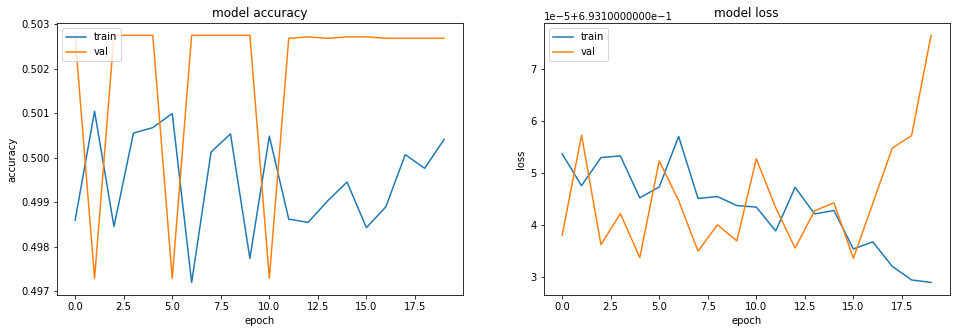

In [128]:
import keras
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(LSTM_history.history['accuracy'])
plt.plot(LSTM_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(LSTM_history.history['loss'])
plt.plot(LSTM_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()